# Easy 21 assignment
### Exercise instructions:
In this assignment, we want to learn the state-value function for a given policy \pi
Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits,
plus other player’s policies of your choice.  For each of the 2 policies, and for each
algorithm, plot the optimal value function v_\pi using similar axes to the Figure 5.2 (right)
from Sutton and Barto’s book. Note that now the dealer can show either a black or a red card.

### Possible actions:
- stick - Don't draw any new cards
- hit - draw new card

### State definition:
- Values of the player’s cards (added (black cards) or subtracted (red cards))
- Value of dealer's cards

### State-Action transitions:
- stick -> draw new card
- hit -> The dealer always sticks on any sum of 17 or greater, and hits otherwise.

### Draw card:
- number 1-10 uniform distribution
- Color: 1/3 red 2/3 black


# Part 1 - Implementation of Easy21 simulator

In [1]:
# %load easy21.py

##################################################################################################
#                                  Environment implementation                                    #
##################################################################################################


import random

# defining constants
CARD_MAX_ABS_VALUE = 10
CARD_MIN_ABS_VALUE = 1
RED = "red"
BLACK = "black"
HIT = 0
STICK = 1
PLAYER = 0
DEALER = 1

# fixing random seed
random.seed(10)

class State:
    def __init__(self):
        self.random = random.Random()
        self.playerPoints = random.randint(CARD_MIN_ABS_VALUE, CARD_MAX_ABS_VALUE)
        self.dealerPoints = random.randint(CARD_MIN_ABS_VALUE, CARD_MAX_ABS_VALUE)

    def updateState(self, card, agent):
        if agent == PLAYER:
            self.playerPoints += card.value
        else:
            self.dealerPoints += card.value

class Card(object):
    def __init__ (self):
        self.color = Card.getColor()
        self.absValue = random.randint(CARD_MIN_ABS_VALUE, CARD_MAX_ABS_VALUE)
        self.value = self.absValue if self.color == BLACK else -self.absValue

    @staticmethod
    def getColor():
        colorVariable = random.randint(1,3)
        return RED if colorVariable == 1 else BLACK

class Policy:
    def act(self, state):
        pass

class DefaultDealerPolicy(Policy):
    def act(self, state):
        if state.dealerPoints >= 17:
            return STICK

        return HIT
    
class DefaultPlayerPolicy(Policy):
    def act(self, state):
        if state.playerPoints >= 20:
            return STICK

        return HIT

class EpisodeStep:
    def __init__(self, state, action, reward, timeStep):
        self.state = state
        self.action = action
        self.reward = reward
        self.timeStep = timeStep
    def __str__(self):
        return "(S, A, R, t) = ({0}, {1}, {2}, {3})".format(str(self.state), "hit" if self.action == 0 else "stick" , str(self.reward), self.timeStep)


class Game:
    def __init__(self, playerPolicy, debug = False):
        self.currentState = State()
        self.playerPolicy = playerPolicy
        self.dealerPolicy = DefaultDealerPolicy()
        self.debug = debug


    def rewardFunction(self, state):
        if state.playerPoints > 21 or state.playerPoints < 1:
            return -1
        if state.dealerPoints > 21 or state.dealerPoints < 1:
            return 1
        if not self.stateIsTerminal(state):
            return 0
        if state.dealerPoints == state.playerPoints:
            return 0
        if state.playerPoints - state.dealerPoints > 0:
            return 1
        else:
            return -1

    def stateIsTerminal(self, state):
        if state.playerPoints > 21 or state.playerPoints < 1:
            return True
        if state.dealerPoints > 21 or state.dealerPoints < 1:
            return True
        return False

    def step (self, agent, action, state):
        if self.debug: print(state.playerPoints, state.dealerPoints)
        card = Card()
        if self.debug: print ("{}:".format("player" if agent == 0 else "dealer"), card.value, card.color)
        state.updateState(card, agent)
        return self.rewardFunction(state)

    def SimulateDealerPlay(self, state):
        dealerAction = self.dealerPolicy.act(state)
        while dealerAction == HIT and not self.stateIsTerminal(state):
            self.step(DEALER, dealerAction, state)
            dealerAction = self.dealerPolicy.act(state)

    def SimulateEpisode(self):
        episodes = []
        t = 0
        self.currentState = State()
        playerAction = self.playerPolicy.act(self.currentState)
        while playerAction == HIT and not self.stateIsTerminal(self.currentState):
            stateTuple = (self.currentState.playerPoints, self.currentState.dealerPoints)
            reward = self.step(PLAYER, playerAction, self.currentState)
            episodes.append(EpisodeStep(stateTuple, playerAction, reward, t))
            t += 1
            playerAction = self.playerPolicy.act(self.currentState)


        self.SimulateDealerPlay(self.currentState)

        if self.debug: print("End state:", self.currentState.playerPoints, self.currentState.dealerPoints)

        episodes[-1].reward = self.rewardFunction(self.currentState)
        return episodes

In [2]:
##################################################################################################
#                                         Environment test                                       #
##################################################################################################

game = Game(DefaultPlayerPolicy())

for i in range (10):
    episodes = game.SimulateEpisode()
    for e in episodes:
        print (e)
    print ("-------------------------------------")

(S, A, R, t) = ((7, 8), hit, 0, 0)
(S, A, R, t) = ((8, 8), hit, -1, 1)
-------------------------------------
(S, A, R, t) = ((8, 5), hit, 0, 0)
(S, A, R, t) = ((11, 5), hit, 0, 1)
(S, A, R, t) = ((2, 5), hit, 0, 2)
(S, A, R, t) = ((8, 5), hit, 0, 3)
(S, A, R, t) = ((4, 5), hit, 0, 4)
(S, A, R, t) = ((10, 5), hit, 0, 5)
(S, A, R, t) = ((3, 5), hit, -1, 6)
-------------------------------------
(S, A, R, t) = ((6, 7), hit, 0, 0)
(S, A, R, t) = ((11, 7), hit, 0, 1)
(S, A, R, t) = ((16, 7), hit, 0, 2)
(S, A, R, t) = ((19, 7), hit, -1, 3)
-------------------------------------
(S, A, R, t) = ((6, 3), hit, 0, 0)
(S, A, R, t) = ((10, 3), hit, 1, 1)
-------------------------------------
(S, A, R, t) = ((9, 6), hit, 0, 0)
(S, A, R, t) = ((3, 6), hit, 0, 1)
(S, A, R, t) = ((12, 6), hit, 0, 2)
(S, A, R, t) = ((19, 6), hit, 1, 3)
-------------------------------------
(S, A, R, t) = ((3, 4), hit, 0, 0)
(S, A, R, t) = ((7, 4), hit, 0, 1)
(S, A, R, t) = ((6, 4), hit, 0, 2)
(S, A, R, t) = ((11, 4), hit,

# Auxiliary functions and imports for the tests

In [3]:
##################################################################################################
#                                             Imports                                            #
##################################################################################################

%matplotlib inline
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from sys import argv
import random

In [4]:
##################################################################################################
#                                         Auxiliary methods                                      #
##################################################################################################

def getFirstVisits(episode):
    firstVisits = {}
    for t in range(len(episode)):
        step = episode[t]
        if not step.state in firstVisits:
            firstVisits[step.state] = t
    
    return firstVisits

def plotValueFunction(vPi):
    x = list(map(lambda x: x[0][0], vPi))
    y = list(map(lambda y: y[0][1], vPi))
    z = list(map(lambda x: x[1], vPi))
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel('Player card sum')
    ax.set_ylabel('Dealer initial card')
    ax.set_zlabel('State value')
    surf = ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.jet, linewidth=0.1)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Generation of the test episodes for each policy

## An episode is a list of episode steps

## An episode step is given as:
- A state identifier, which is a tuple representing the sum of player's cards and the value of initial dealer card
- an integer representing an action: 0 for hit, 1 for stick
- an integer value representing the reward
- an integer representing the time step


In [5]:
##################################################################################################
#                                           Default Policy                                       #
##################################################################################################

# the default player policy is defined inside the environment definition

numberOfEpisodes = 1000

# Generate episode Sample for default Policy
episodesDefaultPlayerPolicy = []
game = Game(DefaultPlayerPolicy())
for i in range(numberOfEpisodes):
    episodesDefaultPlayerPolicy.append(game.SimulateEpisode())

In [6]:
##################################################################################################
#                                         Arbitrary Policy                                       #
##################################################################################################

class ArbitraryPlayerPolicy(Policy):
    def act(self, state):
        if state.playerPoints >= 15 and random.random() > .9:
            return STICK

        return HIT

numberOfEpisodes = 1000

episodesArbitraryPlayerPolicy = []
game = Game(ArbitraryPlayerPolicy())
for i in range(numberOfEpisodes):
    episodesArbitraryPlayerPolicy.append(game.SimulateEpisode())

# Part 2 - Monte Carlo prediction

In [7]:
##################################################################################################
#            Definition of first-visit Monte Carlo method for policy prediction                  #
##################################################################################################

def MonteCarloPrediction(episodes):
    # Generic Monte Carlo initialization
    v = defaultdict(lambda: 0)
    returns = defaultdict(lambda: [])
    n = defaultdict(lambda: 0)
    # Monte Carlo Prediction for given policy
    for episode in episodes:
        G = 0
        firstVisit = getFirstVisits(episode)
        for e in reversed(episode):
            G = G + e.reward
            if firstVisit[e.state] == e.timeStep:
                returns[e.state].append(G)
                n[e.state] += 1
                v[e.state] += 1/n[e.state] * (G - v[e.state])
    return list(v.items())

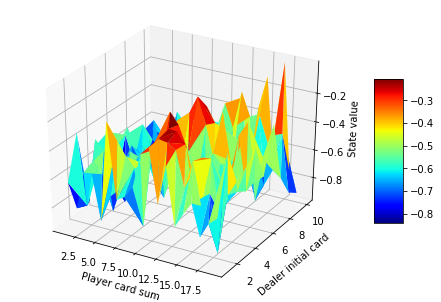

In [26]:
##################################################################################################
# Monte Carlo for Default Policy episodes
##################################################################################################

v = MonteCarloPrediction(episodesDefaultPlayerPolicy)

plotValueFunction(v)

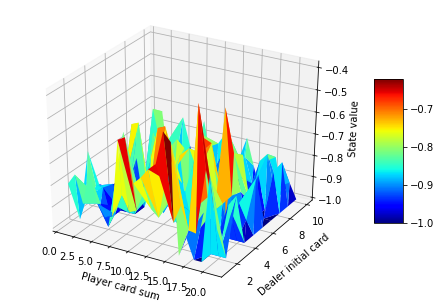

In [9]:
##################################################################################################
# Monte Carlo for Arbitrary Policy episodes
##################################################################################################

v = MonteCarloPrediction(episodesArbitraryPlayerPolicy)

plotValueFunction(v)

# Part 3 - TD(0) preditcion

In [10]:
##################################################################################################
#definition of TD(0) method for policy prediction
##################################################################################################

def TDZeroPrediction(episodes, gamma = .9):
    # Generic TD (0) initialization
    v = defaultdict(lambda: 0)
    n = defaultdict(lambda: 0)
    # TD (0) Prediction for given policy
    for episode in episodes:
        for t in range(len(episode)):
            s = episode[t]
            nextStateValue = v[episode[t+1].state] if t < len(episode)-1 else 0
            n[s.state] += 1
            v[s.state] += 1/n[s.state] * (s.reward + gamma * nextStateValue - v[s.state])
                
                
    return list(v.items())

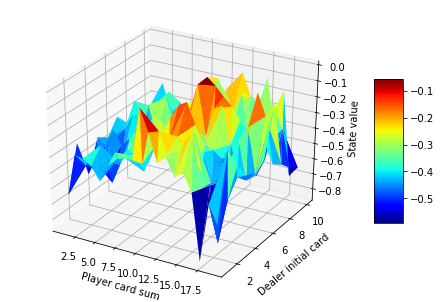

In [11]:
##################################################################################################
# TD (0) for Default Policy episodes
##################################################################################################

v = TDZeroPrediction(episodesDefaultPlayerPolicy)

plotValueFunction(v)

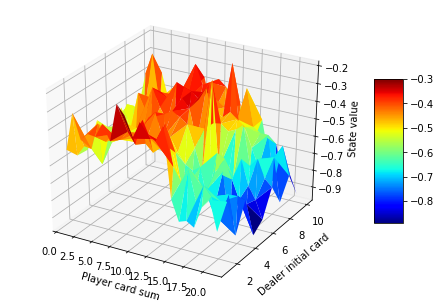

In [12]:
##################################################################################################
# TD (0) for Arbitrary Policy episodes
##################################################################################################

v = TDZeroPrediction(episodesArbitraryPlayerPolicy)

plotValueFunction(v)

# Part 4 - TD(Lambda) preditcion

$V(S_t) \leftarrow V(S_t) + [G^\lambda_t - V(S_t)]$.

Where:

$G_t^\lambda = (1-\lambda) \sum_{n=1}^{T-t-1}\lambda^{n-1}G_t^n + \lambda^{T-t-1}G_t$

$G_t^n = R_{t+1}+\gamma R_{t+2}+ \gamma R_{t+3}...+\gamma^{n-1}R_{t+n} + \gamma^n V(S_{t+n})$


In [27]:
##################################################################################################
#definition of TD(lambda) method for policy prediction
##################################################################################################

def Gn(n, gamma, v, t, episode):
    G = 0
    lenEpisode = len(episode)
    n = min(n, lenEpisode - t)
    
    for step in range(t, t+n):
        G += pow(gamma, step-t) * episode[step].reward

    if t+n < lenEpisode:
        G += pow(gamma, n)*v[episode[n+t].state]
    
    return G

def Gt (gamma, v, t, episode):
    G = 0
    lenEpisode = len(episode)
    n = lenEpisode - t
    
    for step in range(t, t+n):
        G += pow(gamma, step-t) * episode[step].reward

    if t+n < lenEpisode:
        G += pow(gamma, n)*v[episode[n+t].state]
    
    return G

def GLambda (lam, t, episode, v, gamma):
    lenEpisode = len(episode)
    GLam = 0
    for n in range (1,lenEpisode+1):
        GLam += pow(lam, n-1)*Gn(n, gamma, v, t, episode)
    
    return GLam * (1-lam) + pow(lam, lenEpisode-t) * Gt(gamma, v, t, episode)

def TDLambdaPrediction(episodes, gamma = 1, lam=.1):
    # Generic TD(Lambda) initialization
    v = defaultdict(lambda: 0)
    n = defaultdict(lambda: 0)
    # TD(Lambda) Prediction for given policy
    for episode in episodes:
        for t in range(len(episode)):
            s = episode[t]
            n[s.state] += 1
            v[s.state] += 1/n[s.state] * (GLambda(lam, t, episode, v, gamma) - v[s.state])
                
    return list(v.items())

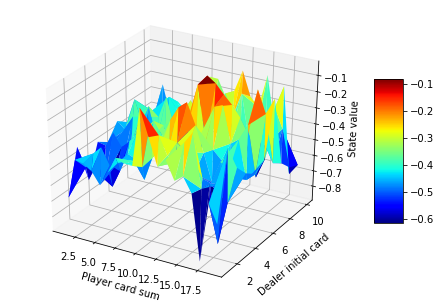

In [28]:
##################################################################################################
# TD(lambda), lambda = 0. This graph is identical to the one for TD(0), which proves that
# TD(lambda) = TD (0) when lambda = 0
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=0)

plotValueFunction(v)

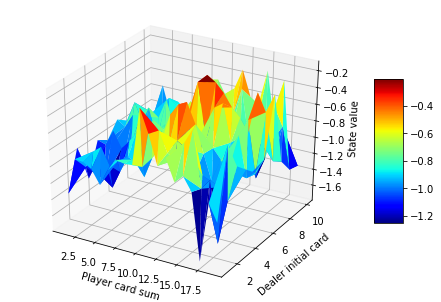

In [15]:
##################################################################################################
# TD(lambda), lambda = 0.1
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.1)

plotValueFunction(v)

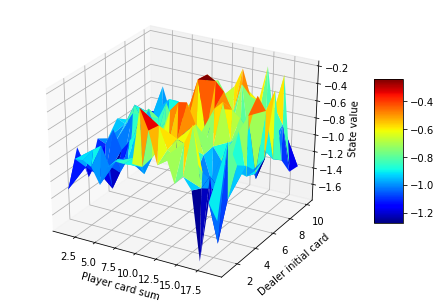

In [16]:
##################################################################################################
# TD(lambda), lambda = 0.2
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.2)

plotValueFunction(v)

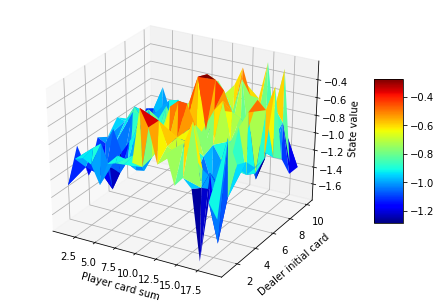

In [17]:
##################################################################################################
# TD(lambda), lambda = 0.3
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.3)

plotValueFunction(v)

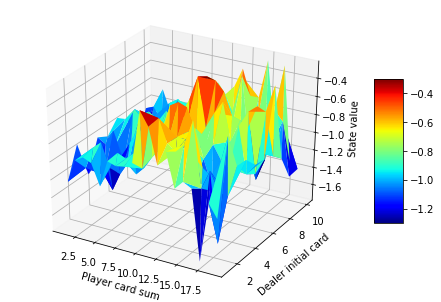

In [18]:
##################################################################################################
# TD(lambda), lambda = 0.4
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.4)

plotValueFunction(v)

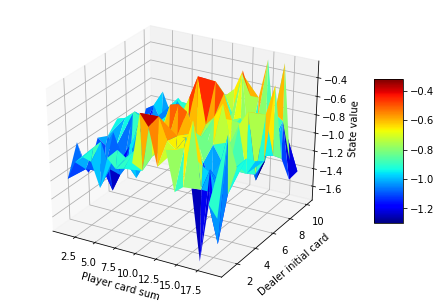

In [19]:
##################################################################################################
# TD(lambda), lambda = 0.5
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.5)

plotValueFunction(v)

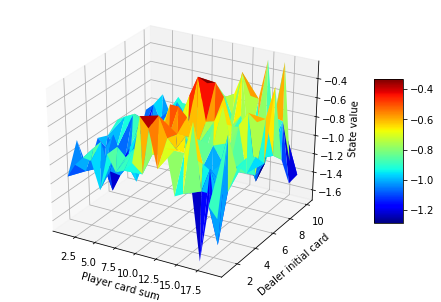

In [20]:
##################################################################################################
# TD(lambda), lambda = 0.6
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.6)

plotValueFunction(v)

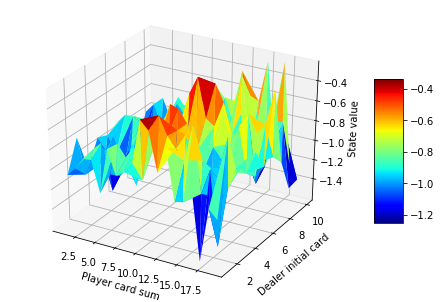

In [21]:
##################################################################################################
# TD(lambda), lambda = 0.7
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.7)

plotValueFunction(v)

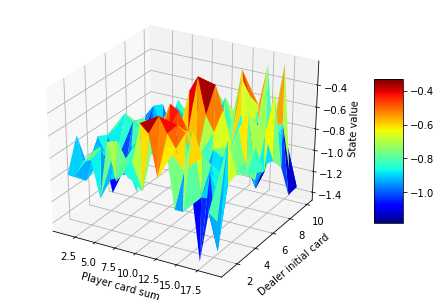

In [22]:
##################################################################################################
# TD(lambda), lambda = 0.8
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.8)

plotValueFunction(v)

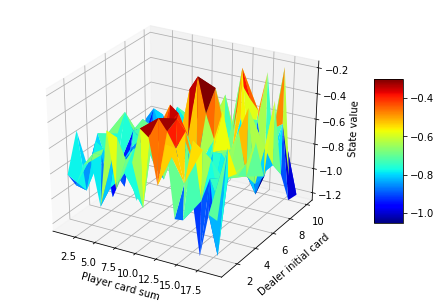

In [23]:
##################################################################################################
# TD(lambda), lambda = 0.9
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=.9)

plotValueFunction(v)

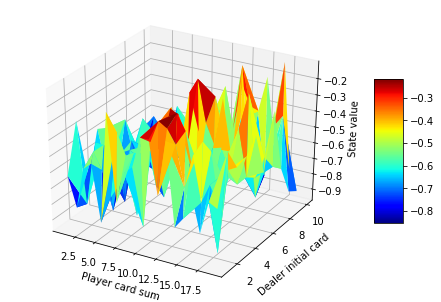

In [29]:
##################################################################################################
# TD(lambda), lambda = 1. The graph below is exactly the one for Monte carlo prediction
# This poves that when lambda = 1, TD(lambda) = MonteCarlo
##################################################################################################

v = TDLambdaPrediction(episodesDefaultPlayerPolicy, lam=1)

plotValueFunction(v)

# Part 5 - Discussion

- What are the pros and cons of bootstrapping in Easy21:prediction?

    As can be concluded from the observation of the figures corresponding to the Monte Carlo method and TD methods for a same policy, boostrapping drastically drastically decreases the variance yielding to a much more reliable value function.
    But on the other hand there is the bias due to the value-function initialization.

- Would you expect bootstrapping to help more in blackjack or Easy21:prediction? Why?

    Since in blackjack, the presence of the ace and other figure cards increases the variance of the possible sums and bootstrapping tends to be less sensible to variances in the return values, it should be expected that applying bootstrapping to black jack would be of more help in blackjack game then in Easy21.

- Verify that TD(lambda -> 0) is equivalent to TD(0).
    
    The update rule used for TD(0) in this implementation is:
    
    $V(S_t) \leftarrow V(S_t) + [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$.
    
    And the update rule for TD(lambda) is:
    
    $V(S_t) \leftarrow V(S_t) + [G^\lambda_t - V(S_t)]$.
    
    Where:
    
    $G_t^\lambda = (1-\lambda) \sum_{n=1}^{T-t-1}\lambda^{n-1}G_t^n + \lambda^{T-t-1}G_t$
    
    $G_t^n = R_{t+1}+\gamma R_{t+2}+ \gamma R_{t+3}...+\gamma^{n-1}R_{t+n} + \gamma^n V(S_{t+n})$
    
    So, if lambda = 0, we have that:
    
    $G_t^0 = (1-\lambda) \sum_{n=1}^{T-t-1}\lambda^{n-1}G_t^n + \lambda^{T-t-1}G_t = (1-0) (0^0 G_t^n + \sum_{n=2}^{T-t-1}\lambda^{n-1}G_t^n) + 0$, for n = 1
    
    $G_t^n = G_t^1 = R_{t+1} + \gamma V(S_{t+1})$, for n = 1
    
    From where we conclude that the update rule for TD(lambda) will be:
    
    $V(S_t) \leftarrow V(S_t) + [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$.
    

- Verify that TD(lambda -> 1) is equivalent to MC.
    
   Just as above, let's consider the update rule for Monte Carlo, which is:
   
   $V(S_t) \leftarrow V(S_t) + [G_t - V(S_t)]$.
   
   And now derive this rule from the TD(lambda) update rule:
   
   $V(S_t) \leftarrow V(S_t) + [G^\lambda_t - V(S_t)]$.
   
   So for lambda = 1 we have:
   
   $G_t^\lambda = (1-\lambda) \sum_{n=1}^{T-t-1}\lambda^{n-1}G_t^n + \lambda^{T-t-1}G_t = (1 - 1) \sum_{n=1}^{T-t-1}\lambda^{n-1}G_t^n + (1)^{T-t-1}G_t$
   
   $G_t^\lambda = G_t$
   
   Which leads us to:

    $V(S_t) \leftarrow V(S_t) + [G_t - V(S_t)]$.
